Fashion MNIST is a drop-in replacement for the very well known, machine learning hello world, MNIST dataset. It has same number of training and test examples and the images have the same 28x28 size and there are a total of 10 classes/labels, you can read more about the dataset here : [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)



## Approach

VGG Like Model With Batchnorm

Split the original training data into 80% training and 20% validation. This helps to see weather we're over-fitting on the training data and weather we should lower the learning rate and train for more epochs if validation accuracy is higher than training accuracy or stop over-training if training accuracy shift higher than the validation.

The model is initially trained for 10 epochs and another 10 epochs with a lower learning late. After the initial 20 epochs, data augmentation is added, which generates new training samples by rotating, shifting and zooming on the training samples, and trained for another 50 epochs.

Also, to avoid hot encoding the labels, `sparse_categorical_crossentropy` is used when compiling the models.

# Required Libaries

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
np.random.seed(12345)
%matplotlib inline

/usr/local/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
tf.__version__

'1.4.0-rc1'

In [3]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="14.04.5 LTS, Trusty Tahr"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 14.04.5 LTS"
VERSION_ID="14.04"
HOME_URL="http://www.ubuntu.com/"
SUPPORT_URL="http://help.ubuntu.com/"
BUG_REPORT_URL="http://bugs.launchpad.net/ubuntu/"


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2016 NVIDIA Corporation
Built on Tue_Jan_10_13:22:03_CST_2017
Cuda compilation tools, release 8.0, V8.0.61


In [5]:
!nvidia-smi

Mon Dec 10 17:21:34 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           Off  | 00000000:00:03.0 Off |                  N/A |
| N/A   42C    P0    40W / 125W |      0MiB /  4036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Download and Load Fashion-MNIST

In [6]:
batch_size = 512

In [7]:
train_images_path = keras.utils.get_file('train-images-idx3-ubyte.gz', 'https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz')
train_labels_path = keras.utils.get_file('train-labels-idx1-ubyte.gz', 'https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-labels-idx1-ubyte.gz')
test_images_path = keras.utils.get_file('t10k-images-idx3-ubyte.gz', 'https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz')
test_labels_path = keras.utils.get_file('t10k-labels-idx1-ubyte.gz', 'https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz')

8192/5148 [===============================================] - 0s 0us/step


In [8]:
def load_mnist(images_path, labels_path):
    import os
    import gzip
    import numpy as np

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


In [9]:
X_train_orig, y_train_orig = load_mnist(train_images_path, train_labels_path)
X_test, y_test = load_mnist(test_images_path, test_labels_path)
X_train_orig = X_train_orig.astype('float32')
X_test = X_test.astype('float32')
X_train_orig /= 255
X_test /= 255

In [10]:
print(X_train_orig.shape)
print(y_train_orig.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=12345)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)


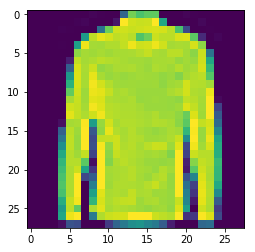

In [13]:
plt.imshow(X_train[1, :].reshape((28, 28)))

### Data Augmentation

In [14]:
img_rows = 28
img_cols = 28
input_shape = (img_rows, img_cols, 1)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [15]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=batch_size)
val_batches = gen.flow(X_val, y_val, batch_size=batch_size)

In [16]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)
def norm_input(x): return (x-mean_px)/std_px

In [ ]:
!pip install --upgrade keras

In [ ]:
!pip install --upgrade tensorflow

# VGG Like Model With Batchnorm

In [20]:
vgg_cnn = Sequential([
    Lambda(norm_input, input_shape=(28,28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),    
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),    
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

TypeError: softmax() got an unexpected keyword argument 'axis'

In [ ]:
vgg_cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
import time
t0 = time.time()

vgg_cnn.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))

In [ ]:
vgg_cnn.optimizer.lr = 0.0001

In [ ]:
vgg_cnn.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))

In [ ]:
score = vgg_cnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Data Augmentation

In [ ]:
vgg_cnn.fit_generator(batches, steps_per_epoch=48000//batch_size, epochs=50, 
                    validation_data=val_batches, validation_steps=12000//batch_size, use_multiprocessing=True)

In [ ]:
t1 = time.time()
timeit=t1-t0
timeit

In [ ]:

# write out resutls
 
#make confusion matrix plot
def plot_confusion_matrix(cm, target_names, path, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
 
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
 
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
 
    title:        the text to display at the top of the matrix
 
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
 
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
 
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
 
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
 
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
 
    if cmap is None:
        cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.gcf().subplots_adjust(bottom=0.25)
    plt.savefig(path + 'ConfMatx.png', format='png')
    plt.gcf().clear()

In [ ]:
test_loss, test_acc = vgg_cnn.evaluate(X_test, y_test)
predictions = vgg_cnn.predict(X_test)
preds_index = predictions.argmax(axis=1)

In [ ]:
test_acc

In [ ]:
timeit

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
import sklearn as sk
from sklearn import metrics
plot_confusion_matrix(cm           = metrics.confusion_matrix(y_test, preds_index), 
                      normalize    = False,
                      path         = "results/",
                      target_names = class_names,
                      title        = "Confusion Matrix")

In [ ]:
import json
with open('dominostats.json', 'w') as f:
    f.write(json.dumps({"Time": round(timeit, 3), "Acc": round(test_acc, 3)}))